In [601]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import pow
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import joblib
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore') # Ignoring warnings to keep notebook clean and concise
random_state = 0 # Setting a random state variable to keep all results consistent

In [602]:
gfcf = pd.read_csv('Transformed Data/GFCF.csv')

gfcf['Year'] = pd.to_datetime(gfcf['Year'], format='%Y')

gfcf.set_index('Year', inplace=True)

In [603]:
def arima_model(df, order):
    model = ARIMA(df, order=order)
    model_fit = model.fit(disp=False)
    return model_fit

In [604]:
def arima_grid_search(df, p_values, d_values, q_values):
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = arima_model(df, (p,d,q))
                    mse = mean_squared_error(df, model.fittedvalues)
                    rmse = sqrt(mse)
                    if rmse < best_score:
                        best_score, best_order = rmse, (p,d,q)
                except:
                    continue
    return best_score, best_order

In [605]:
def preprocess_data(df):
    return np.log(df)

In [606]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2, 3]
q_values = [0, 1, 2, 3]

# Perform grid search for each country
countries = gfcf['Country'].unique()
for country in countries:
    print(f'Country: {country}')
    df_country = preprocess_data(gfcf[gfcf['Country'] == country]['Construction Value'])
    print(f'Datapoints:{len(df_country)}')
    best_score, best_order = arima_grid_search(df_country, p_values, d_values, q_values)
    print(f'Best ARIMA{best_order} RMSE={best_score}\n')

Country: Austria
Datapoints:8
Best ARIMANone RMSE=inf

Country: Switzerland
Datapoints:7
Best ARIMANone RMSE=inf

Country: Cyprus
Datapoints:8
Best ARIMANone RMSE=inf

Country: Germany
Datapoints:8
Best ARIMANone RMSE=inf

Country: Denmark
Datapoints:8
Best ARIMANone RMSE=inf

Country: Estonia
Datapoints:8
Best ARIMANone RMSE=inf

Country: Greece
Datapoints:8
Best ARIMANone RMSE=inf

Country: Spain
Datapoints:8
Best ARIMANone RMSE=inf

Country: Finland
Datapoints:8
Best ARIMANone RMSE=inf

Country: France
Datapoints:8
Best ARIMANone RMSE=inf

Country: Croatia
Datapoints:8
Best ARIMANone RMSE=inf

Country: Hungary
Datapoints:8
Best ARIMANone RMSE=inf

Country: Ireland
Datapoints:8
Best ARIMANone RMSE=inf

Country: Iceland
Datapoints:8
Best ARIMANone RMSE=inf

Country: Italy
Datapoints:8
Best ARIMANone RMSE=inf

Country: Lithuania
Datapoints:8
Best ARIMANone RMSE=inf

Country: Luxembourg
Datapoints:8
Best ARIMANone RMSE=inf

Country: Latvia
Datapoints:8
Best ARIMANone RMSE=inf

Country: 

ARIMA does not seem to be suitable as a prediction model for the GFCF Construction Value, it seems to not find good values for p,d and q for Arima. This could be due to small datasize, lack of stationality etc.

In [607]:
gfcf_gdp = pd.read_csv('Transformed Data/GFCF-ML.csv')

gfcf_gdp['Year'] = pd.to_datetime(gfcf_gdp['Year'], format='%Y')

data = gfcf_gdp.dropna(axis=0,how='any') # drop empty rows

data.head()


,Year,Percent GDP,Country
0,1996-01-01,6.9,Albania
1,1997-01-01,6.4,Albania
2,1998-01-01,7.1,Albania
3,1999-01-01,7.3,Albania
4,2000-01-01,10.3,Albania


In [608]:
countries = data['Country'].unique()
country_data = {country: data[data['Country'] == country] for country in countries}

In [609]:
model_lr = LinearRegression()
rmse_scores = 0

for country in countries:
    X = pd.DataFrame(country_data[country]['Year'].dt.year)
    y = country_data[country]['Percent GDP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse_scores += sqrt(mse)


print(f'Average RMSE : {rmse_scores/len(countries)}')
print(f'Average MSE : {pow((rmse_scores/len(countries)),2)}')


Average RMSE : 3.9730081820550165
Average MSE : 15.784794014676107


Below is redundant code for checking if a model to predict Percent GDP using Country and year is workable, it is not

data['Year'] = pd.DataFrame(data['Year'].dt.year)

X = data[['Year', 'Country']]
y = data['Percent GDP']

#Convert 'Country' to numerical value
X = pd.get_dummies(X)

#Define models and hyper paramters, linear regression has none
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [10,20,50,100,150]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'learning_rate': [0.1, 0.05, 0.01]})
}

start = datetime.datetime.now()

#Perform GridSearchCV for each model and print the best parameters and score
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best MSE score for {name}: {-grid_search.best_score_}\n")

end = datetime.datetime.now()

duration = end - start
duration = duration.total_seconds()

print(f'Grid Search took {duration} seconds')

In [610]:
countries = data['Country'].unique()
country_data = {country: data[data['Country'] == country] for country in countries}

for country in countries:
    X = pd.DataFrame(country_data[country]['Year'].dt.year)
    y = country_data[country]['Percent GDP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    lasso_reg = Lasso(alpha=0.2)
    lasso_reg.fit(X_train, y_train)
    joblib.dump(lasso_reg, "lasso_reg.h5")
    y_pred = lasso_reg.predict(X_test)
    print(f'{country}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'R2 score : {r2_score(y_test, y_pred)}\n')

Albania
RMSE : 7.204844632856102
R2 score : -0.04274242535469397

Austria
RMSE : 3.5218748691041104
R2 score : -0.022579278106065193

Bosnia and Herzegovina
RMSE : 5.059770401427088
R2 score : 0.0915122190780856

Belgium
RMSE : 2.528050707560319
R2 score : -0.09213549161529078

Bulgaria
RMSE : 4.521665129851133
R2 score : -0.024150386367256305

Switzerland
RMSE : 2.434542614634543
R2 score : -0.08107981374033457

Cyprus
RMSE : 3.43283032845642
R2 score : -0.08672489959251917

Czechia
RMSE : 4.628336002185655
R2 score : -0.02893482462163033

Germany
RMSE : 2.8144416412821287
R2 score : -0.012206103589284423

Denmark
RMSE : 2.8567138711821594
R2 score : -0.13251837269522992

Estonia
RMSE : 5.958366791791677
R2 score : -0.07645654318110884

Greece
RMSE : 3.0403579935361633
R2 score : 0.3914870380139014

Spain
RMSE : 4.141595876854359
R2 score : 0.029402528800159033

Invalid country code
RMSE : 2.7316735855830125
R2 score : -0.07056205802150117

Finland
RMSE : 4.148398354520755
R2 score : 

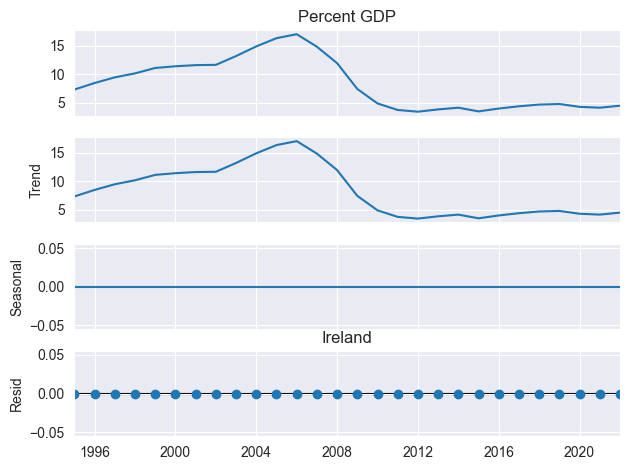

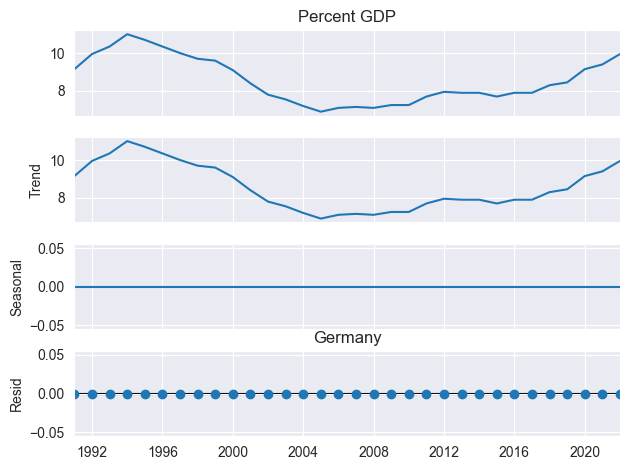

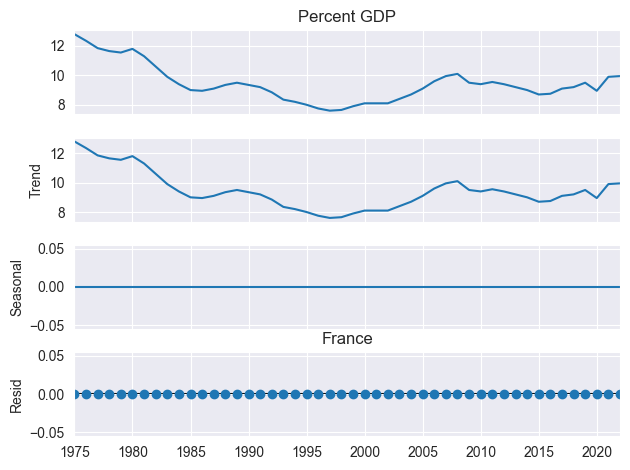

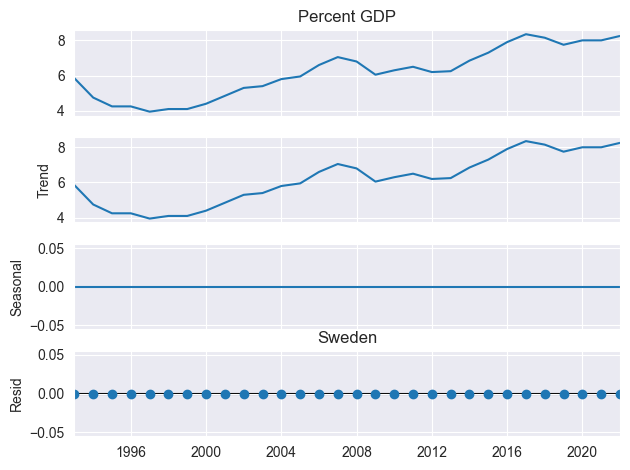

In [611]:
data = gfcf_gdp.copy()

df = data.groupby(['Country', 'Year']).mean().reset_index()

countries = ['Ireland','Germany','France','Sweden']

for country in countries:
    df_country = df[df['Country'] == country]
    df_country['Year'] = pd.to_datetime(df_country['Year'], format="%Y")
    df_country.set_index('Year', inplace=True)
    df_country = df_country.asfreq('YS')

    # check if there are enough data points (at least 2) for decomposition
    if df_country.shape[0] > 2:
        decomposition = seasonal_decompose(df_country['Percent GDP'])

        # Plot decomposition
        decomposition.plot()
        plt.title(country)
        plt.show()